In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data Exploration

## Load processed data

In [2]:
# Storing file path locally, change for your system
negative_images_path="./data/2img_mask_npy/negative_imgs.npy"
negative_masks_path="./data/2img_mask_npy/negative_masks.npy"
negative_names_path="./data/2img_mask_npy/negative_imgs_names.npy"

positive_images_path="./data/2img_mask_npy/positive_imgs.npy"
positive_masks_path="./data/2img_mask_npy/positive_masks.npy"
positive_names_path="./data/2img_mask_npy/positive_imgs_names.npy"

In [ ]:
negative_images = np.load(negative_images_path)
negative_masks = np.load(negative_masks_path)
negative_names = np.load(negative_names_path)

positive_images = np.load(positive_images_path)
positive_masks = np.load(positive_masks_path)
positive_names = np.load(positive_names_path)

## Plotting examples

In [16]:
def plt_img_mask(img, msk, ax):
    ax.imshow(img, cmap='gray')  # Call imshow on the axis
    ax.imshow(msk, cmap='jet', alpha=0.3)  # Overlay the mask
    ax.axis('off')  # Turn off the axis

fname: 1.2.276.0.7230010.3.1.4.8323329.5222.1517875187.61027.png
fname: 1.2.276.0.7230010.3.1.4.8323329.2583.1517875173.593347.png
fname: 1.2.276.0.7230010.3.1.4.8323329.338.1517875162.455978.png
fname: 1.2.276.0.7230010.3.1.4.8323329.2218.1517875171.672924.png
fname: 1.2.276.0.7230010.3.1.4.8323329.4509.1517875183.211958.png


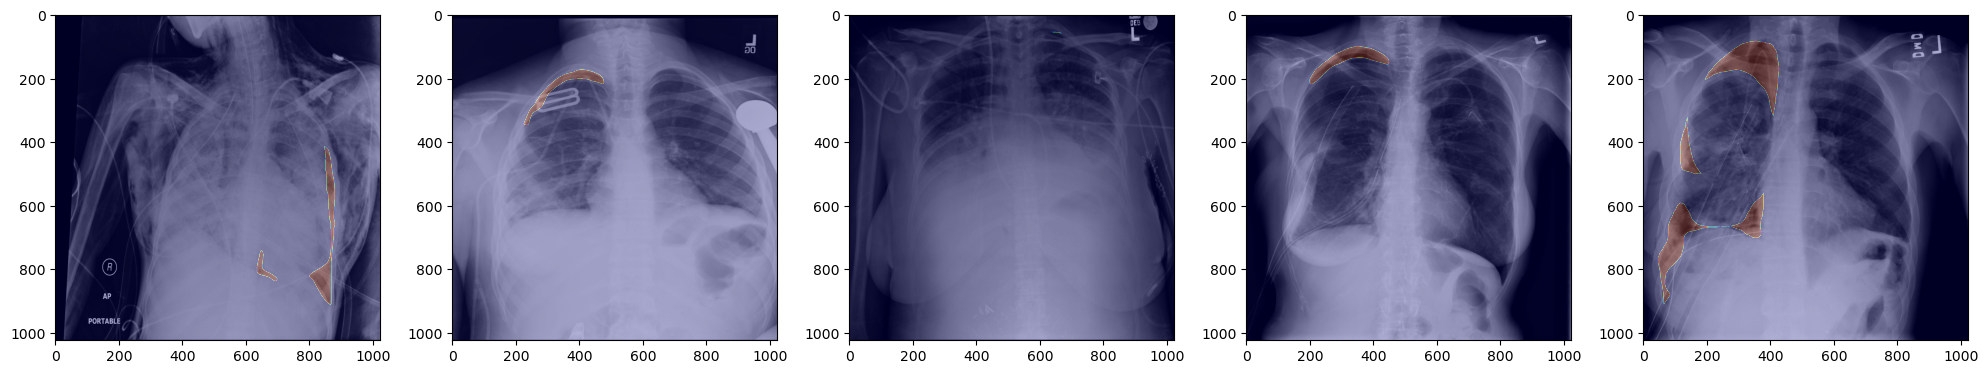

In [ ]:
# Plotting Positive Images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create a row of 5 subplots

for i in range(5):  # Loop over the 5 subplots
    plt_img_mask(positive_images[i], positive_masks[i], positive_names[i], axs[i])

plt.tight_layout()
plt.show()

fname: 1.2.276.0.7230010.3.1.4.8323329.4015.1517875180.661259.png
fname: 1.2.276.0.7230010.3.1.4.8323329.3895.1517875180.10946.png
fname: 1.2.276.0.7230010.3.1.4.8323329.32383.1517875160.322522.png
fname: 1.2.276.0.7230010.3.1.4.8323329.3909.1517875180.73776.png
fname: 1.2.276.0.7230010.3.1.4.8323329.13419.1517875245.240854.png


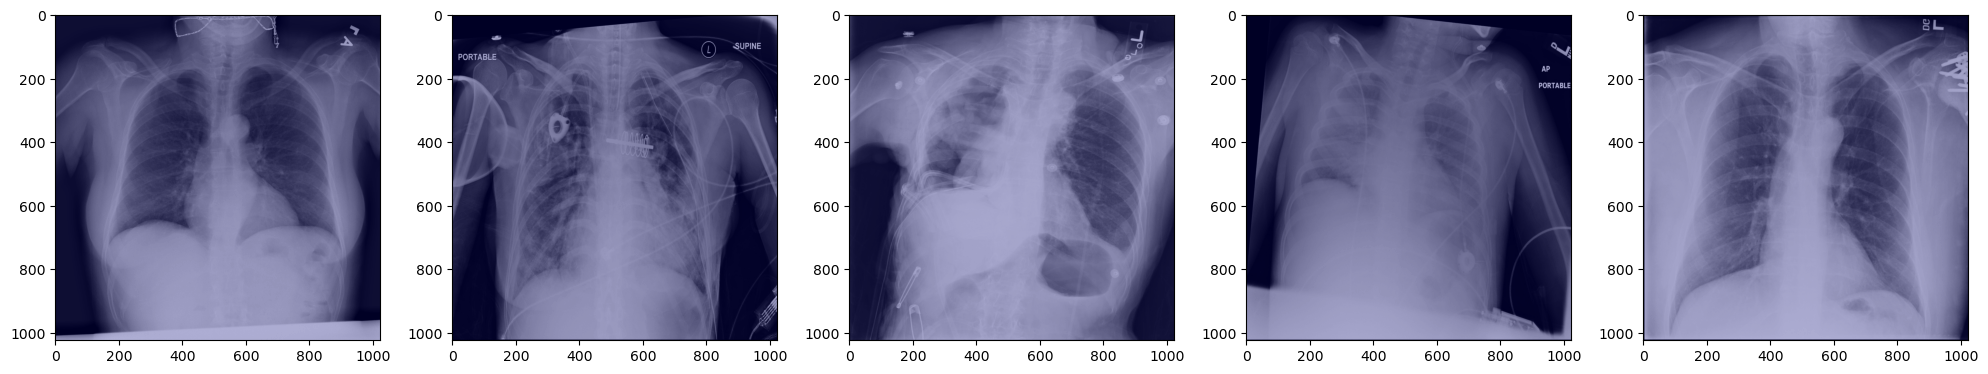

In [ ]:
# Plotting Negative Images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create a row of 5 subplots

for i in range(5):  # Loop over the 5 subplots
    plt_img_mask(negative_images[i], negative_masks[i], negative_names[i], axs[i])

plt.tight_layout()
plt.show()

## Data Augmentation Display

In [3]:
positive_names_path="./data/2img_mask_npy/positive_imgs_names.npy"
negative_names_path="./data/2img_mask_npy/negative_imgs_names.npy"
positive_names = np.load(positive_names_path)
negative_names = np.load(negative_names_path)
print(f"Amount of positive samples: {len(positive_names)}")
print(f"Amount of negative samples: {len(negative_names)}")

Amount of positive samples: 2669
Amount of negative samples: 9378


In [ ]:
train_names = np.concatenate((positive_names, negative_names))
exist_labels = np.concatenate((np.ones(len(positive_names)), np.zeros(len(negative_names))))

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_labels = np.zeros(len(train_names))
for i, (train_index, val_index) in enumerate(skf.split(train_names, exist_labels)):
    fold_labels[val_index] = i
np.save("./data/2img_mask_npy/fold_labels.npy", fold_labels)

In [5]:
import albumentations as albu

img_size = 512
train_transform = albu.Compose([
    albu.HorizontalFlip(),
    albu.OneOf([
        albu.RandomGamma(),
        albu.RandomBrightnessContrast(),
        ], p=0.5),
    albu.OneOf([
        albu.ElasticTransform(alpha=10),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=(-0.2, 0.2), 
                               shift_limit=(-0.2, 0.2)),
        ], p=0.3),
    albu.ShiftScaleRotate(),
    albu.Resize(img_size, img_size, always_apply=True),
    # albu.Normalize()
])

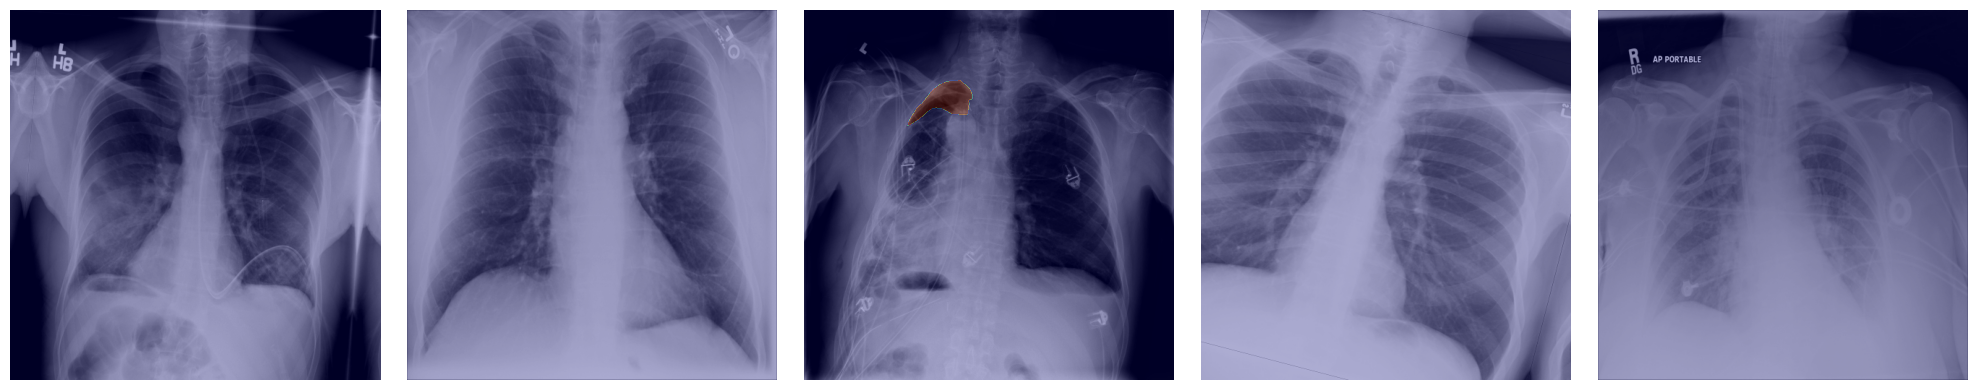

In [ ]:
from dataset import PneumoDataset

fold_labels = np.load("./data/2img_mask_npy/fold_labels.npy")
train_dataset = PneumoDataset(mode="train", fold_index=0, 
                              train_name=train_names, fold_labels=fold_labels, exist_labels=exist_labels, transform=train_transform)

# Displaying 5 images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create a row of 5 subplots
img_idx = np.random.choice(len(train_dataset), 5)  # Get 5 random indices
for i in range(5):  # Loop over the 5 subplots
    img, msk = train_dataset[img_idx[i]]  # Get the image and mask
    img = img.numpy().transpose(1, 2, 0)  # Transpose the image
    plt_img_mask(img, msk, axs[i])  # Plot the image and mask

plt.tight_layout()
plt.show()

# Model Summary

In [33]:
from torchsummary import summary
from model import ResUNet
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResUNet(1, 32, pretrained=False)
model.to(device)

summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
            Conv2d-2         [-1, 64, 256, 256]           9,408
       BatchNorm2d-3         [-1, 64, 256, 256]             128
       BatchNorm2d-4         [-1, 64, 256, 256]             128
              ReLU-5         [-1, 64, 256, 256]               0
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,864
           Conv2d-10         [-1, 64, 128, 128]          36,864
      BatchNorm2d-11         [-1, 64, 128, 128]             128
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
             ReLU-14         [-1, 64, 1